# Correlation analysis between the Ethereum currency and Twitter

This project consists of a correlation analysis between the Ethereum currency and tweets. In order to define the positiveness of a tweet (if the course of the ETH will go up or down), we realise a sentiment analysis of each tweet using the VADER and TextBlob algorithm. Finally we try to find a correlation between the two and we will make some deep learning to make predictions -> made in a seperate notebook

This notebook was written using Python 3.6.

## Import the Python dependencies

For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

- *pip install VaderSentiment*
- *pip install pandas*
- *pip install tqdm*

We will create a requirements.txt file closer to completion

In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## Load the datasets 

We read the data generated from the first notebook, Tweets_Clean_and_Analysis. The retrieval process is detailed in the notebook so please refer to that for any information needed. The Ethereum data is collected from Binance. Here we simply gather all the retrieved data to generate two datasets:

- The twitter dataset : contains historical tweets related to the targeted crypto currency with a sentiment score.
- The crypo dataset : contains historical data of the crypto currency we target with the change in USD.

### Twitter dataset 

In [2]:
tw_df = pd.read_csv('tweets_sentiment.csv')
tw_df.head(5)

,created_at,clean_tweet,compound
0,2022-05-18 12:55:34 EST,ethereum pos has been soon for four years,0.0000
1,2022-05-18 12:31:46 EST,Ethereum's main testnet set for proof-of-stake...,0.0000
2,2022-05-18 12:20:19 EST,Cloudflare announced its support for the devel...,0.3472
3,2022-05-18 12:16:58 EST,VROOM VROOM Welcome to the Bitbuy team Devlin ...,0.4588
4,2022-05-18 12:15:33 EST,Robinhood will launch a non-custodial Ethereum...,0.0000


In [3]:
tw_df.shape

(10615, 3)

In [4]:
print(tw_df.dtypes)

created_at      object
clean_tweet     object
compound       float64
dtype: object


In [5]:
# checking there's no missing values after exporting to csv
tw_df.isna().sum()

created_at     0
clean_tweet    0
compound       0
dtype: int64

In [6]:
tw_df.rename(columns={'created_at': 'date_time'}, inplace = True)
print(tw_df.columns)

Index(['date_time', 'clean_tweet', 'compound'], dtype='object')


### Crypto dataset

In [7]:
crypto_df = pd.read_csv('Binance_ETHUSD_2022_2021_min.csv')
crypto_df.head(5)

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
0,1.650000e+12,18/05/2022 23:00,ETH/USDT,1946.53,1951.26,1946.05,1951.26,1107.673,2.159588e+06,1846
1,1.650000e+12,18/05/2022 22:59,ETH/USDT,1949.28,1949.28,1946.53,1946.53,414.808,8.080278e+05,881
2,1.650000e+12,18/05/2022 22:58,ETH/USDT,1948.00,1949.65,1946.09,1949.33,1347.837,2.625623e+06,1757
3,1.650000e+12,18/05/2022 22:57,ETH/USDT,1948.90,1949.00,1941.14,1948.00,3880.517,7.543657e+06,4938
4,1.650000e+12,18/05/2022 22:56,ETH/USDT,1946.80,1949.21,1946.79,1948.89,595.312,1.159578e+06,990


In [8]:
crypto_df.isna().sum() 

unix           0
date           0
symbol         0
open           0
high           0
low            0
close          0
Volume ETH     0
Volume USDT    0
tradecount     0
dtype: int64

In [9]:
# Export to csv for correlation analysis-extract relevant columns 
# crypto_df.to_csv('eth_extract.csv', index = False, columns = ['date','close'])

In [10]:
d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M')
eth_df = pd.read_csv('eth_extract.csv', parse_dates=['date'], date_parser = d_parser)
eth_df.head(2)

,date,close
0,2022-05-18 23:00:00,1951.26
1,2022-05-18 22:59:00,1946.53


### Convert to datetime objects before using groupby () function

In [11]:
# For convenience lets rename the eth_df date column as well
eth_df.rename(columns={'date': 'date_time'}, inplace = True)
print(eth_df.columns)

Index(['date_time', 'close'], dtype='object')


In [12]:
# Convert 'date_time' columns from objects to datetime objects
tw_df["date_time"] = pd.to_datetime(tw_df["date_time"])
eth_df["date_time"] = pd.to_datetime(eth_df["date_time"], format = '%d/%m/%Y %H:%M')

In [13]:
# Needed sorting for merging bit later
eth_sorted = eth_df.sort_values(by='date_time')
print(eth_sorted)

                 date_time    close
200579 2021-12-30 16:00:00  3711.38
200578 2021-12-30 16:01:00  3712.80
200577 2021-12-30 16:02:00  3707.12
200576 2021-12-30 16:03:00  3713.78
200575 2021-12-30 16:04:00  3714.49
...                    ...      ...
4      2022-05-18 22:56:00  1948.89
3      2022-05-18 22:57:00  1948.00
2      2022-05-18 22:58:00  1949.33
1      2022-05-18 22:59:00  1946.53
0      2022-05-18 23:00:00  1951.26

[200580 rows x 2 columns]


In [14]:
eth_sorted.set_index('date_time', inplace = True)

The sentiment time series will be discussed later in this section. The closing price as well as the time and date were selected for modelling. But for now we need to match the sentiment time series

In [15]:
eth_filt = eth_sorted['2021-12-30 16:00:00':'2022-05-18 11:00:00']

### Groupby and sum by timeframe 

**Note to self:** What I need to do is first is group the tweets. Then merge the "eth_filt" datatframe close price to its respective time

In [132]:
fq = '60min'
# trial [15,20,30,40,45,60]

tweets_grouped = tw_df.groupby(pd.Grouper(key='date_time',freq = fq))['compound'].sum()
tweets_grouped
# test different intervals

date_time
2021-12-30 16:00:00    0.6369
2021-12-30 17:00:00    0.2840
2021-12-30 18:00:00    0.9917
2021-12-30 19:00:00    0.7684
2021-12-30 20:00:00    0.0000
                        ...  
2022-05-18 08:00:00    1.7687
2022-05-18 09:00:00   -0.5719
2022-05-18 10:00:00    0.3176
2022-05-18 11:00:00    0.6592
2022-05-18 12:00:00    0.8367
Freq: 60T, Name: compound, Length: 3333, dtype: float64

In [133]:
crypto_usd_grouped= eth_filt.reset_index().groupby(pd.Grouper(key='date_time', freq = fq))['close'].mean()
crypto_usd_grouped

date_time
2021-12-30 16:00:00    3737.526500
2021-12-30 17:00:00    3744.747333
2021-12-30 18:00:00    3743.750167
2021-12-30 19:00:00    3757.146500
2021-12-30 20:00:00    3742.932833
                          ...     
2022-05-18 07:00:00    2027.950167
2022-05-18 08:00:00    2030.275500
2022-05-18 09:00:00    2030.540000
2022-05-18 10:00:00    2039.970167
2022-05-18 11:00:00    2041.190000
Freq: 60T, Name: close, Length: 3332, dtype: float64

In [80]:
tweets_grouped = tweets_grouped.round(4)

In [81]:
crypto_usd_grouped = crypto_usd_grouped.round(2)

## Visualise and Plot 

We calculate the sum of each tweets grouped by the selected frequency and then we plot it

In [90]:
# Lets merge the df to see them match to match
merged_df = pd.merge(tweets_grouped, crypto_usd_grouped, on = "date_time")
merged_df

,compound,close
date_time,,
2021-12-30 16:45:00,0.6369,3754.196667
2021-12-30 17:00:00,0.0000,3749.915333
2021-12-30 17:15:00,0.0000,3746.068000
2021-12-30 17:30:00,0.0000,3741.925333
2021-12-30 17:45:00,0.2840,3741.080667
...,...,...
2022-05-18 10:00:00,0.0000,2040.380667
2022-05-18 10:15:00,0.0000,2042.784000
2022-05-18 10:30:00,-0.1260,2039.636667


In [83]:
def min_max_mean(coin, df):
    print("Minumum compound ", coin," :" ,df['compound'].min())
    print("Maximum compound ", coin," :" ,df['compound'].max())
    print("\n")

min_max_mean('ETH',merged_df)

Minumum compound  ETH  : -4.8352
Maximum compound  ETH  : 5.4763




In [136]:
#merged_df.to_csv('crypto.csv')

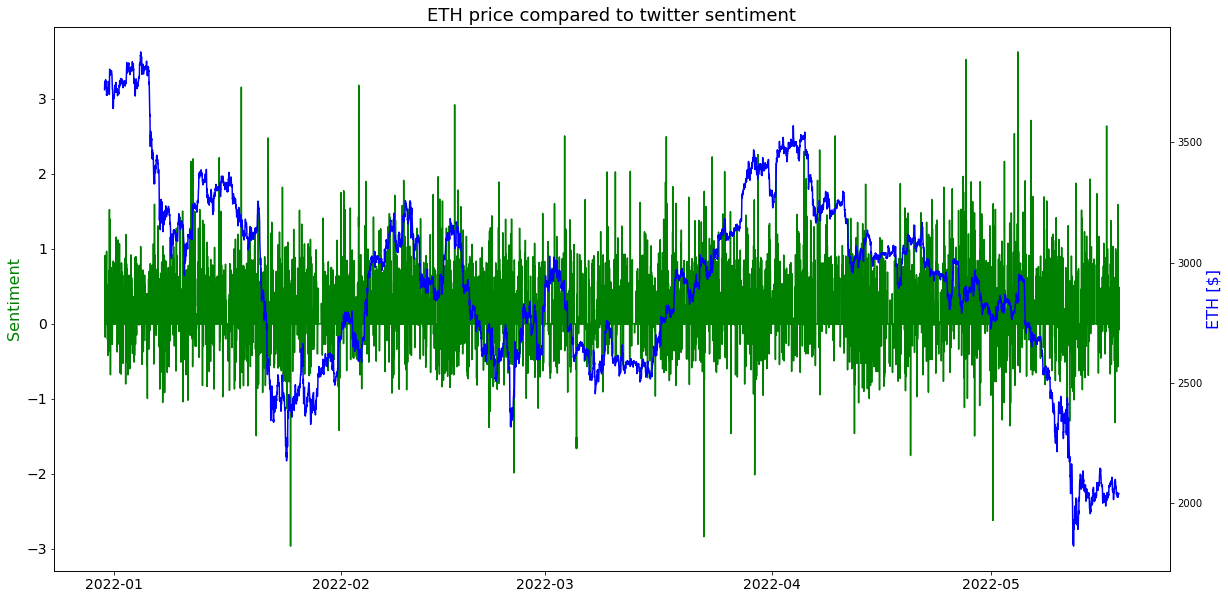

In [95]:
# (Ahmed Nauman and Shubhankar Mohapatra 2022)
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("ETH price compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("ETH [$]", color='b', fontsize=16)
plt.show()

## Correlation analysis (VADER)

Let's do a correlation analysis between ETH/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

In [134]:
# Define the cross-correlation function
# Ahmed Nauman and Shubhankar Mohapatra 2022. KryptoOracle: A Real-Time Cryptocurrency Price Prediction Platform Using Twitter Sentiments. [online] GitHub. Available at: https://github.com/Nomiizz/KryptoOracle/blob/master/04_TwitterSentimentAndCryptocurrencies.ipynb.
# The following code of the cross correlation analysis is referenced from the link above

def cross_corr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    cross_corr : float
    """
    return datax.corr(datay.shift(lag), method=method)

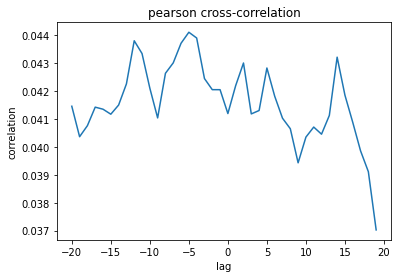

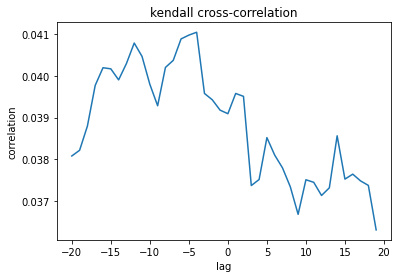

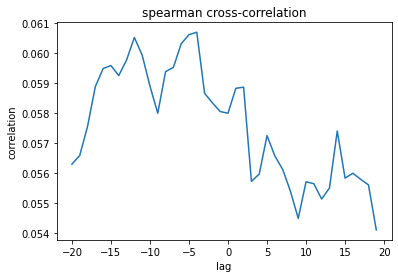

In [135]:
# (Ahmed Nauman and Shubhankar Mohapatra 2022)
xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Compute derivative


The derivative is calculated to define an increase or a decrease of the crypto currency.

The compound score is as well derivated to observe the increase or decrease of the score.

Computing the derivative could help to find a correlation.

In [26]:
# Derivative
# (Ahmed Nauman and Shubhankar Mohapatra 2022)
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

In [27]:
tweets_grouped

date_time
2021-12-30 16:45:00   -0.63690
2021-12-30 17:00:00   -0.31845
2021-12-30 17:15:00    0.00000
2021-12-30 17:30:00    0.14200
2021-12-30 17:45:00    0.45610
                        ...   
2022-05-18 11:45:00   -0.48355
2022-05-18 12:00:00    0.72030
2022-05-18 12:15:00    0.26335
2022-05-18 12:30:00   -0.68170
2022-05-18 12:45:00    0.00000
Freq: 15T, Name: slope, Length: 13329, dtype: float64

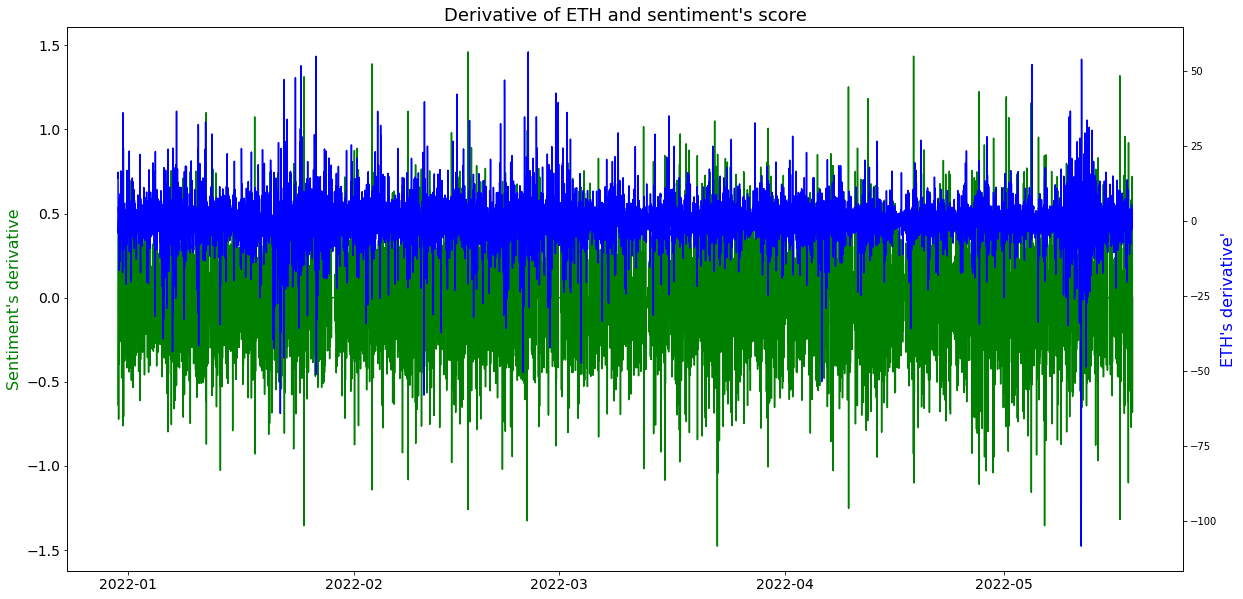

In [28]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of ETH and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel("ETH's derivative'", color='b', fontsize=16)
plt.show()

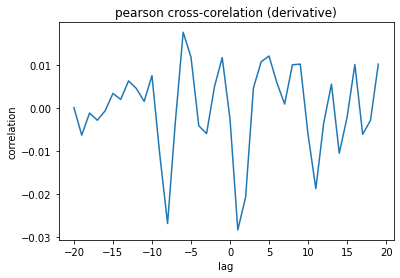

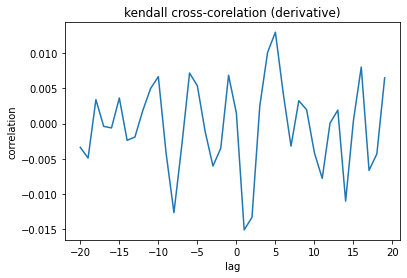

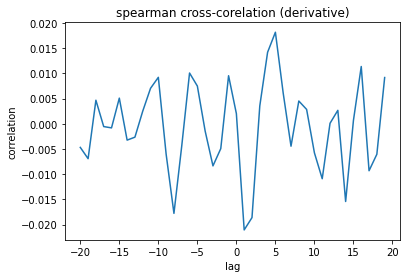

In [29]:
# (Ahmed Nauman and Shubhankar Mohapatra 2022)
xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [cross_corr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

# TextBlob correlation analysis

Let's implement the same cross correlation analysis but for the TextBlob scores this time, bare in mind we have done most of the work.  

In [30]:
textblob_df = pd.read_csv('tweets_sentiment_textblob.csv')
textblob_df.head(5)

,created_at,clean_tweet,polarity
0,2022-05-18 11:55:34 EST,ethereum pos has been soon for four years,0.000000
1,2022-05-18 11:31:46 EST,Ethereum's main testnet set for proof-of-stake...,0.133333
2,2022-05-18 11:20:19 EST,Cloudflare announced its support for the devel...,0.000000
3,2022-05-18 11:16:58 EST,VROOM VROOM Welcome to the Bitbuy team Devlin ...,0.525000
4,2022-05-18 11:15:33 EST,Robinhood will launch a non-custodial Ethereum...,0.000000


In [31]:
textblob_df.shape

(10615, 3)

In [32]:
textblob_df.rename(columns={'created_at': 'date_time'}, inplace = True)
print(textblob_df.columns)

Index(['date_time', 'clean_tweet', 'polarity'], dtype='object')


### Convert textblob_df to datetime object before using groupby () function

In [33]:
textblob_df["date_time"] = pd.to_datetime(textblob_df["date_time"])

### Groupby and sum by timeframe 

In [122]:
fq = '60min'
# trial [15,20,30,40,45,60]

tweets_grouped_tb = textblob_df.groupby(pd.Grouper(key='date_time',freq = fq))['polarity'].mean()
tweets_grouped_tb
# test different intervals

date_time
2021-12-30 16:00:00    0.500000
2021-12-30 17:00:00    0.028571
2021-12-30 18:00:00    0.125734
2021-12-30 19:00:00    0.416667
2021-12-30 20:00:00    0.000000
                         ...   
2022-05-18 07:00:00    0.138048
2022-05-18 08:00:00    0.003125
2022-05-18 09:00:00    0.041667
2022-05-18 10:00:00    0.082500
2022-05-18 11:00:00    0.065625
Freq: 60T, Name: polarity, Length: 3332, dtype: float64

In [123]:
crypto_usd_grouped_tb= eth_filt.reset_index().groupby(pd.Grouper(key='date_time', freq = fq))['close'].mean()
crypto_usd_grouped_tb

date_time
2021-12-30 16:00:00    3737.526500
2021-12-30 17:00:00    3744.747333
2021-12-30 18:00:00    3743.750167
2021-12-30 19:00:00    3757.146500
2021-12-30 20:00:00    3742.932833
                          ...     
2022-05-18 07:00:00    2027.950167
2022-05-18 08:00:00    2030.275500
2022-05-18 09:00:00    2030.540000
2022-05-18 10:00:00    2039.970167
2022-05-18 11:00:00    2041.190000
Freq: 60T, Name: close, Length: 3332, dtype: float64

## Plot

In [36]:
# Lets merge the df to see them match to match
merged_df_tb = pd.merge(tweets_grouped_tb, crypto_usd_grouped_tb, on = "date_time")
merged_df_tb

,polarity,close
date_time,,
2021-12-30 16:00:00,0.500000,3737.526500
2021-12-30 17:00:00,0.028571,3744.747333
2021-12-30 18:00:00,0.125734,3743.750167
2021-12-30 19:00:00,0.416667,3757.146500
2021-12-30 20:00:00,0.000000,3742.932833
...,...,...
2022-05-18 07:00:00,0.138048,2027.950167
2022-05-18 08:00:00,0.003125,2030.275500
2022-05-18 09:00:00,0.041667,2030.540000


In [37]:
# Mean,MAX,MIN for polarity score
def min_max_mean(coin, df):
    print("Minumum compound ", coin," :" ,df['polarity'].min())
    print("Maximum compound ", coin," :" ,df['polarity'].max())
    print("\n")
    
min_max_mean('ETH',merged_df_tb)

Minumum compound  ETH  : -0.625
Maximum compound  ETH  : 1.0




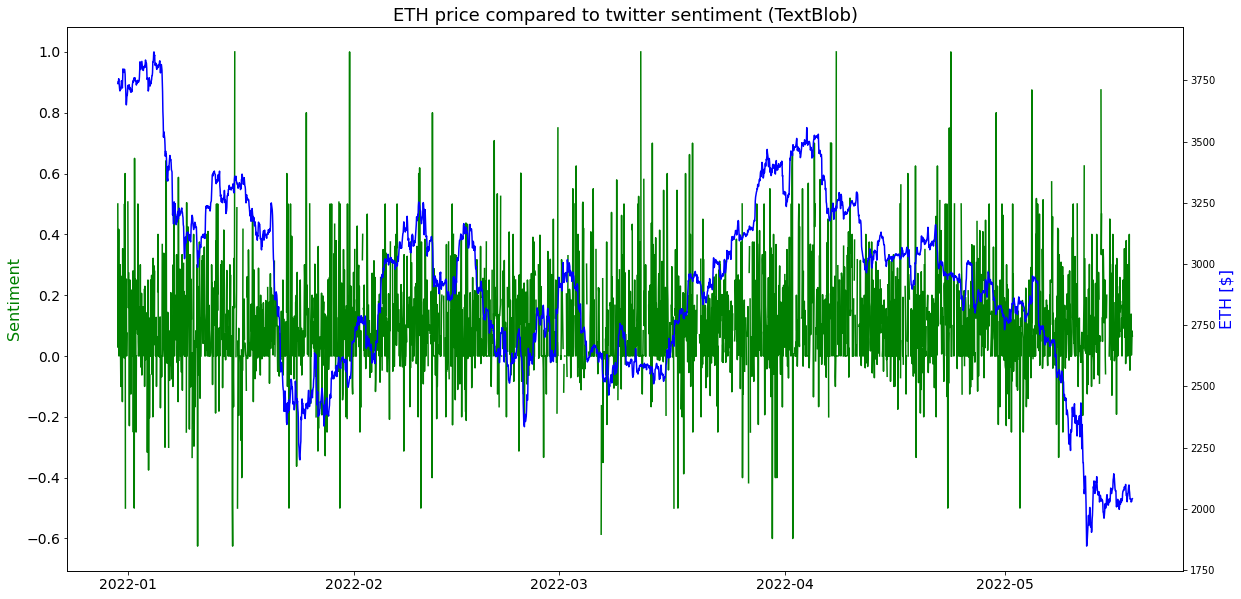

In [38]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("ETH price compared to twitter sentiment (TextBlob)", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_tb.index, tweets_grouped_tb, 'g-')
ax2.plot_date(crypto_usd_grouped_tb.index, crypto_usd_grouped_tb, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("ETH [$]", color='b', fontsize=16)
plt.show()

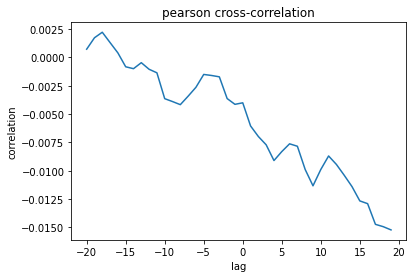

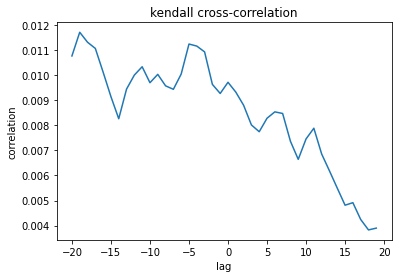

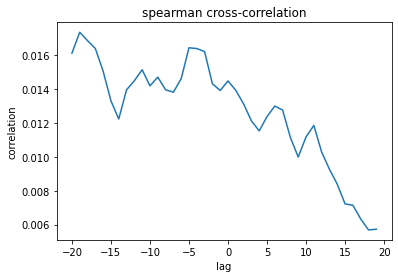

In [124]:
xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative

In [40]:
# Derivative
tweets_grouped_tb = pd.Series(np.gradient(tweets_grouped_tb.values), tweets_grouped_tb.index, name='slope')
crypto_usd_grouped_tb = pd.Series(np.gradient(crypto_usd_grouped_tb.values), crypto_usd_grouped_tb.index, name='slope')

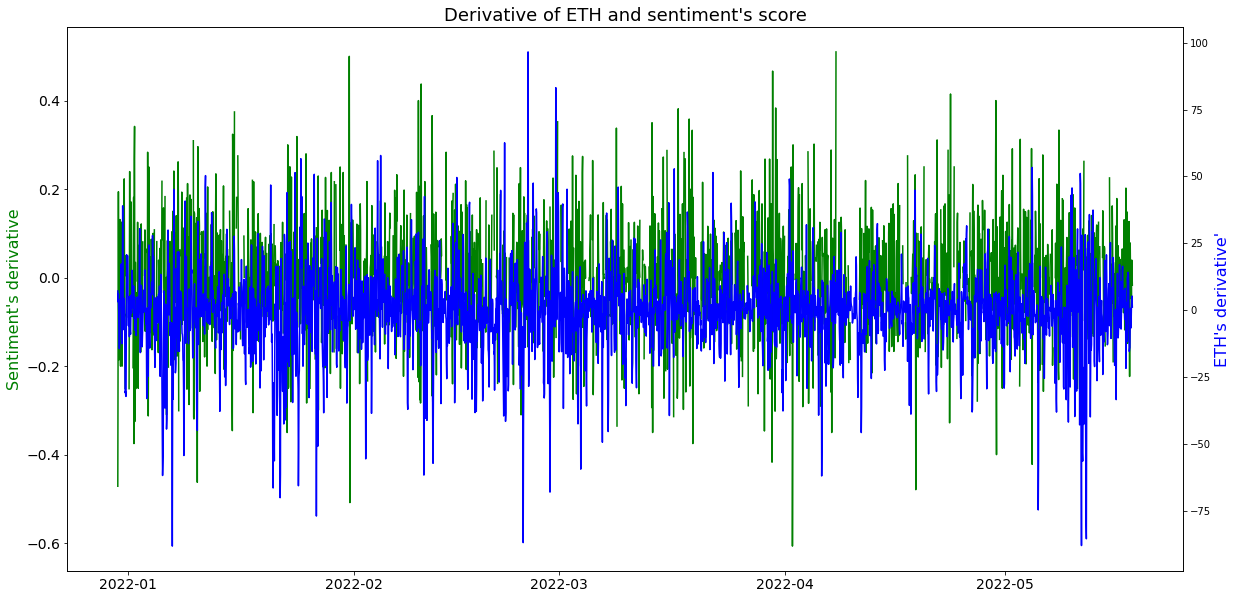

In [41]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of ETH and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_tb.index, tweets_grouped_tb, 'g-')
ax2.plot_date(crypto_usd_grouped_tb.index, crypto_usd_grouped_tb, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel("ETH's derivative'", color='b', fontsize=16)
plt.show()

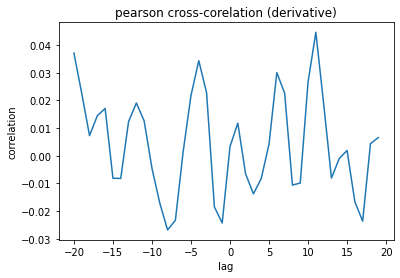

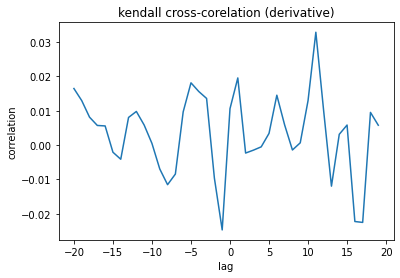

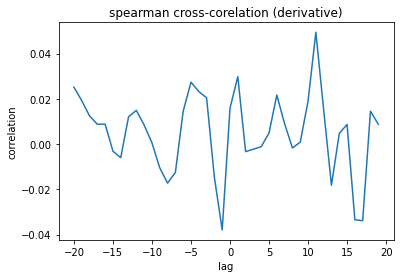

In [42]:
# (Ahmed Nauman and Shubhankar Mohapatra 2022)
xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov2 = [cross_corr(tweets_grouped_tb, crypto_usd_grouped_tb, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov2)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()